In [23]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [24]:
import numpy as np
import pandas as pd

In [25]:
import datetime as dt
#from datatime import datetime,strptime

# Reflect Tables into SQLAlchemy ORM

In [26]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [27]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [28]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [29]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [30]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [31]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

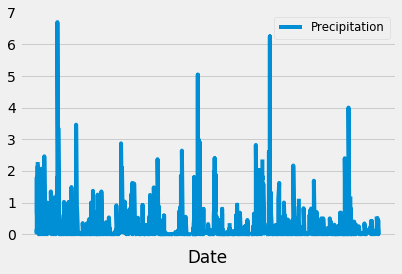

In [32]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results



# Calculate the date 1 year ago from the last data point in the database

last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date = dt.datetime.strptime(last_date[0], '%Y-%m-%d')

year_ago = last_date - dt.timedelta(days=366)

# Perform a query to retrieve the data and precipitation scores

prcp_date = session.query(Measurement.prcp,Measurement.date).filter(Measurement.date >= year_ago).order_by(Measurement.date).all()

prcp = [i[0] for i in prcp_date]
date = [i[1] for i in prcp_date]

# Save the query results as a Pandas DataFrame and set the index to the date column

prcp1 = pd.DataFrame({"Precipitation":prcp,"Date":date})

# Use Pandas Plotting with Matplotlib to plot the data
plt.plot(prcp1.Date,prcp1.Precipitation)
plt.legend(fontsize='small')
plt.xlabel("Date")
plt.xticks([])
plt.show()

In [33]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df = pd.DataFrame(prcp1.Precipitation.describe())
df

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [34]:
# Design a query to show how many stations are available in this dataset?
station = session.query(func.count(Station.station)).all()
station

[(9)]

In [35]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station,func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [36]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).filter(Measurement.station == active_stations[0][0]).all()

[(54.0, 85.0, 71.66378066378067)]

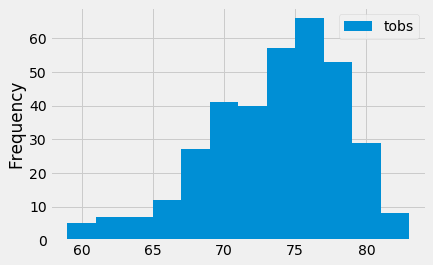

In [37]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs_df = session.query(Measurement.tobs).filter(Measurement.date > year_ago).filter(Measurement.station == active_stations[0][0]).all()

tobs = [i[0] for i in tobs_df]
plt.hist(tobs,bins=12)
plt.ylabel("Frequency")
plt.legend(['tobs'])
plt.show()

In [38]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [42]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_start = '2016-08-20'
trip_end = '2017-05-20'

trip_start_earlier = dt.datetime.strptime(trip_start, '%Y-%m-%d') - dt.timedelta(days=365)
trip_end_earlier = dt.datetime.strptime(trip_end, '%Y-%m-%d') - dt.timedelta(days=365)

results = calc_temps(trip_start_earlier, trip_end_earlier)[0]
minTemp = results[0]
avgTemp = results[1]
maxTemp = results[2]
print(f"{minTemp} {avgTemp} {maxTemp}")

56.0 73.73537762634867 86.0


Text(0,0.5,'Temp (F)')

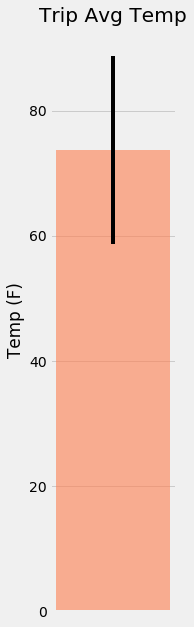

In [43]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

plt.figure(figsize=[2,10])
plt.bar(x=0, height=avgTemp, yerr=(maxTemp-minTemp)/2, color = 'coral', alpha=.6)
plt.grid(axis='x')
plt.xticks([])
plt.title('Trip Avg Temp')
plt.ylabel('Temp (F)')

In [45]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



trip_start = '2012-02-28'
trip_end = '2012-03-05'



rainfall = session.query(Station.station, Station.name, Station.latitude,Station.longitude,Station.elevation,func.sum(Measurement.prcp)).\
                  join(Measurement,Measurement.station == Station.station).\
                  filter(Measurement.date >= trip_start ).\
                  filter(Measurement.date <= trip_end ).\
                  group_by(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation).\
                  order_by(func.sum(Measurement.prcp).desc()).all()
rainfall

[('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  11.08),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  10.32),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 5.79),
 ('USC00518838',
  'UPPER WAHIAWA 874.3, HI US',
  21.4992,
  -158.0111,
  306.6,
  3.8400000000000003),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  2.92),
 ('USC00519397',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  1.1800000000000002),
 ('USC00511918',
  'HONOLULU OBSERVATORY 702.2, HI US',
  21.3152,
  -157.9992,
  0.9,
  0.76),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  0.03),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0)]

## Optional Challenge Assignment

In [46]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [47]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date
trip_start = '2016-04-20'
trip_end = '2016-05-01'

trip_start_date = dt.datetime.strptime(trip_start, "%Y-%m-%d")
trip_end_date = dt.datetime.strptime(trip_end, "%Y-%m-%d")

date_range = []

while (trip_end_date >= trip_start_date):
   date_range.append(dt.datetime.strftime(trip_start_date, '%Y-%m-%d'))
   trip_start_date += dt.timedelta(days=1)

values = []

for i in date_range:
   val = i[5:]
   values.append(daily_normals(val)[0])

values

[(64.0, 72.73684210526316, 80.0),
 (66.0, 72.32142857142857, 78.0),
 (65.0, 72.92727272727272, 84.0),
 (65.0, 73.01818181818182, 79.0),
 (67.0, 73.3103448275862, 80.0),
 (66.0, 73.96551724137932, 83.0),
 (66.0, 74.01724137931035, 81.0),
 (65.0, 72.87272727272727, 81.0),
 (63.0, 73.46428571428571, 79.0),
 (66.0, 73.30357142857143, 81.0),
 (58.0, 71.5576923076923, 78.0),
 (65.0, 72.75925925925925, 79.0)]

In [51]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
pd_values = pd.DataFrame(values, columns = ['TMin', 'TAvg', 'TMax'])

pd_values = pd_values.assign(Date = date_range)

pd_values.set_index(["Date"], inplace = True, drop = True)

pd_values

,TMin,TAvg,TMax
Date,,,
2016-04-20,64.0,72.736842,80.0
2016-04-21,66.0,72.321429,78.0
2016-04-22,65.0,72.927273,84.0
2016-04-23,65.0,73.018182,79.0
2016-04-24,67.0,73.310345,80.0
2016-04-25,66.0,73.965517,83.0
2016-04-26,66.0,74.017241,81.0
2016-04-27,65.0,72.872727,81.0
2016-04-28,63.0,73.464286,79.0


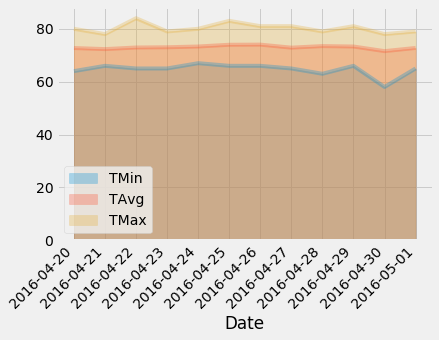

In [54]:
# Plot the daily normals as an area plot with `stacked=False`
ticks = np.arange(0,12)

pd_values.plot.area(stacked=False, alpha = .3)
plt.xticks(ticks, date_range, rotation = 45, horizontalalignment = 'right')
plt.xlabel('Date')
plt.show()